# Tutorial 3-1: The Activation Function Zoo & The Vanishing Gradient

**Course:** CSEN 342: Deep Learning  
**Topic:** Activation Functions, Derivatives, and Gradient Flow

## Objective
The choice of activation function can make or break a deep neural network. While **ReLU** is the standard default, modern architectures like Transformers (BERT, GPT, Llama) and EfficientNets rely on newer, smoother functions like **GELU** and **Swish (SiLU)**.

In this tutorial, we will:
1.  **Visualize the Zoo:** Plot the curves and *derivatives* of both classic and modern activation functions to understand their properties (saturation, linearity, smoothness).
2.  **The Vanishing Gradient Experiment (The Problem):** Train a very deep (50-layer) network with default initialization to see why Sigmoid and Tanh historically failed for deep networks.
3.  **The Fix (Initialization):** Learn how **Xavier** and **Kaiming (He)** initialization schemes solve the vanishing gradient problem, allowing signal to flow through deep networks.
4.  **Domain Guide:** Discuss which activations are best suited for Images, Text (LLMs), Audio, and Scientific data.

---

## Part 1: Visualizing the Zoo

We will look at three generations of activation functions:
1.  **Classic:** Sigmoid, Tanh (The "S-curves")
2.  **The ReLU Family:** ReLU, Leaky ReLU, ELU (The piecewise linear functions)
3.  **Modern Smooth:** GELU, SiLU (Swish), Mish (The non-monotonic functions used in LLMs)

### Why look at the derivative?
During backpropagation, the gradient flows through the activation function via the chain rule:  
$$ \frac{\partial L}{\partial x} = \frac{\partial L}{\partial y} \cdot f'(x) $$
If $f'(x)$ is close to 0 (saturation), the gradient vanishes, and the network stops learning.

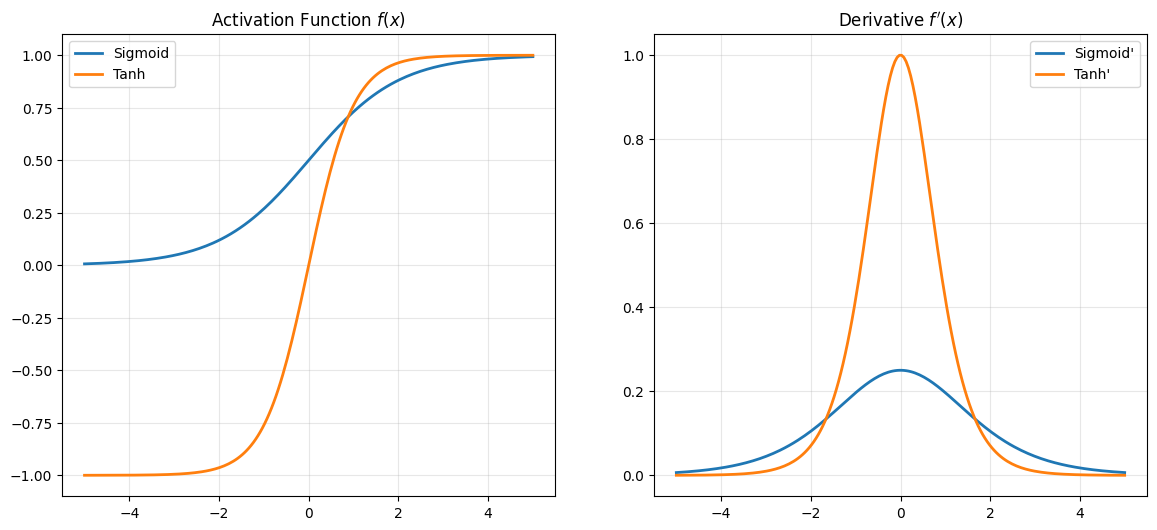

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np

# Define range of inputs
x = torch.linspace(-5, 5, 200, requires_grad=True)

def plot_activation(name, func, ax_f, ax_d):
    # 1. Forward Pass
    y = func(x)
    
    # 2. Backward Pass (Compute Derivative)
    if x.grad is not None:
        x.grad.zero_()
    y.sum().backward()
    grad = x.grad.clone()
    
    # 3. Plot Function
    ax_f.plot(x.detach().numpy(), y.detach().numpy(), label=name, linewidth=2)
    ax_f.set_title("Activation Function $f(x)$")
    ax_f.grid(True, alpha=0.3)
    ax_f.legend()
    
    # 4. Plot Derivative
    ax_d.plot(x.detach().numpy(), grad.detach().numpy(), label=f"{name}'", linewidth=2)
    ax_d.set_title("Derivative $f'(x)$")
    ax_d.grid(True, alpha=0.3)
    ax_d.legend()

# Setup Plotting
fig, axs = plt.subplots(1, 2, figsize=(14, 6))

# --- Group 1: The Classics ---
plot_activation("Sigmoid", torch.sigmoid, axs[0], axs[1])
plot_activation("Tanh", torch.tanh, axs[0], axs[1])

plt.show()

**Observation (Classics):** 
* **Saturation:** Notice that for inputs $>2$ or $<-2$, the derivative (right plot) drops to almost **zero**. This is the "Vanishing Gradient" problem.
* **Zero-Centered:** Tanh is zero-centered (outputs range -1 to 1), while Sigmoid is not (0 to 1). Zero-centering usually helps convergence.

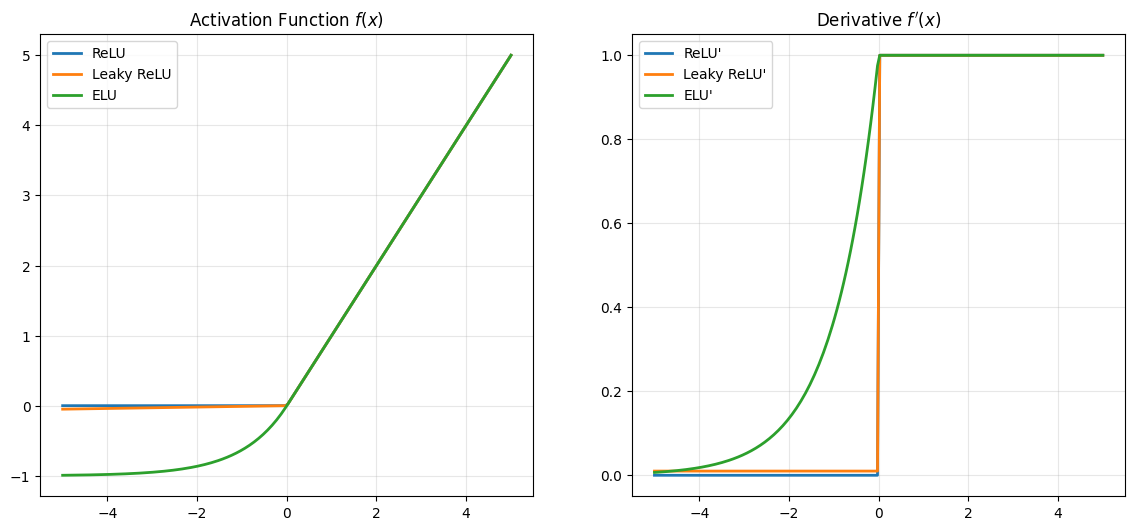

In [2]:
fig, axs = plt.subplots(1, 2, figsize=(14, 6))

# --- Group 2: The ReLU Family ---
plot_activation("ReLU", F.relu, axs[0], axs[1])
plot_activation("Leaky ReLU", F.leaky_relu, axs[0], axs[1])
plot_activation("ELU", F.elu, axs[0], axs[1])

plt.show()

**Observation (ReLU Family):**
* **No Saturation (Positive):** For $x > 0$, the derivative is exactly 1. This solves the vanishing gradient problem for positive inputs.
* **Dead Neurons:** For standard ReLU, if $x < 0$, the derivative is exactly 0. The neuron stops learning entirely.
* **Leaky/ELU:** These try to fix the "dead neuron" problem by allowing a small gradient for negative inputs.

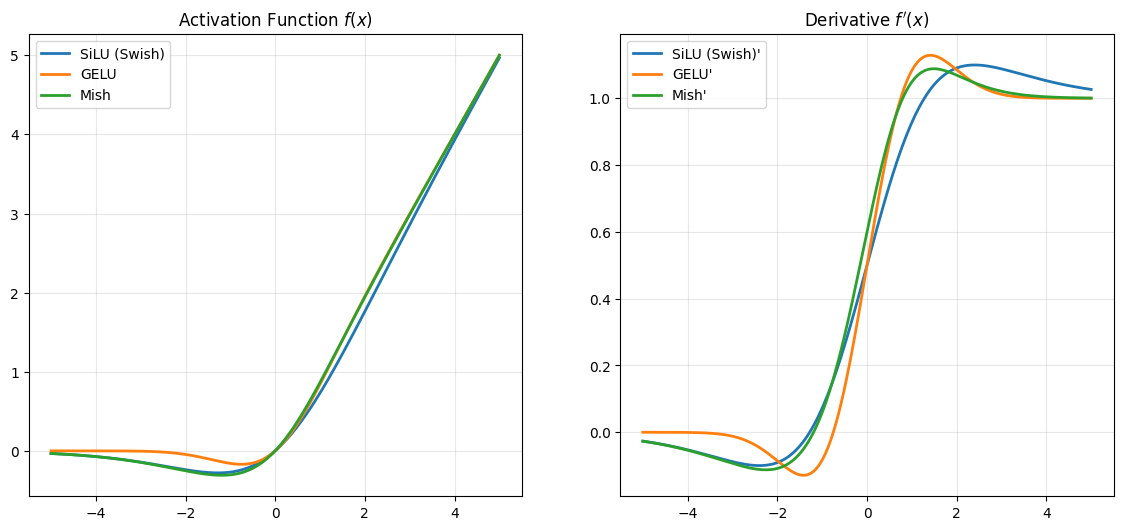

In [3]:
fig, axs = plt.subplots(1, 2, figsize=(14, 6))

# --- Group 3: Modern Smooth (Transformers/LLMs) ---
# SiLU (Swish) = x * sigmoid(x)
plot_activation("SiLU (Swish)", F.silu, axs[0], axs[1])

# GELU (Gaussian Error Linear Unit) - Used in BERT/GPT
plot_activation("GELU", F.gelu, axs[0], axs[1])

# Mish - A newer self-regularized non-monotonic function
plot_activation("Mish", F.mish, axs[0], axs[1])

plt.show()

**Observation (Modern):**
* **Smoothness:** Unlike ReLU, these functions have a smooth curve at $0$. This makes the optimization landscape smoother, which helps very deep networks (like Transformers) train better.
* **Non-Monotonic:** Notice the slight "dip" below zero for negative inputs. This property has been experimentally shown to improve regularization.

---

## Part 2: The Vanishing Gradient Experiment (The Problem)

To visualize the problem, we will simulate a very deep network (**50 Layers**). We will pass random data through it and measure the magnitude of the gradients at each layer.

We will start with **default initialization**, which is not optimized for very deep networks.

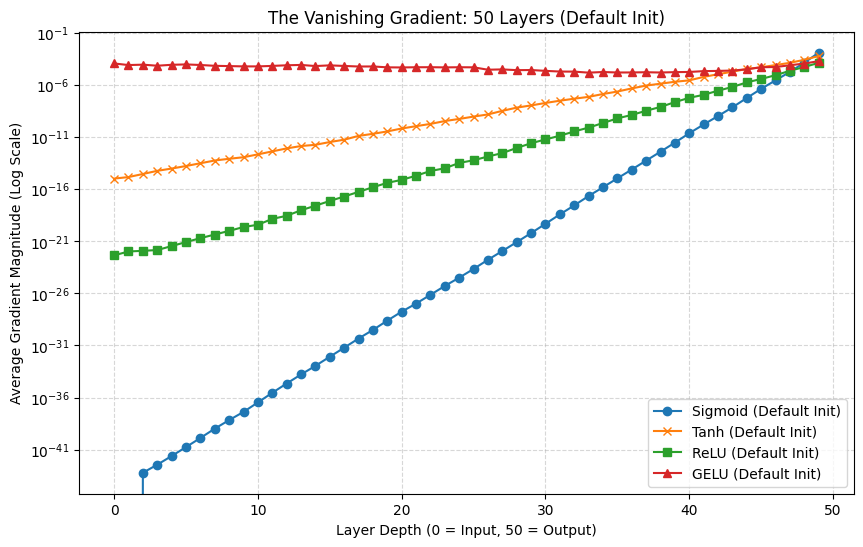

In [4]:
class DeepNet(nn.Module):
    def __init__(self, activation_func, depth=50, hidden_dim=100, custom_init=False, act_name=''):
        super().__init__()
        self.layers = nn.ModuleList()
        self.activation = activation_func
        
        for _ in range(depth):
            layer = nn.Linear(hidden_dim, hidden_dim)
            # Apply custom initialization if requested (Part 3)
            if custom_init:
                if act_name in ['Sigmoid', 'Tanh']:
                    nn.init.xavier_normal_(layer.weight)
                elif act_name in ['ReLU', 'GELU']:
                    nn.init.kaiming_normal_(layer.weight, nonlinearity='relu')
            self.layers.append(layer)

    def forward(self, x):
        for layer in self.layers:
            x = self.activation(layer(x))
        return x

def check_gradients(activation_name, activation_func, custom_init=False):
    # 1. Init Model (50 Layers!)
    model = DeepNet(activation_func, depth=50, custom_init=custom_init, act_name=activation_name)
    if torch.cuda.is_available():
        model = model.cuda()
    
    # 2. Synthetic Data
    device = next(model.parameters()).device
    x = torch.randn(64, 100).to(device)
    
    # 3. Forward & Backward
    output = model(x)
    loss = output.mean()
    loss.backward()
    
    # 4. Collect Gradients
    grads = []
    layers = []
    for i, layer in enumerate(model.layers):
        if layer.weight.grad is not None:
            grad_mag = layer.weight.grad.abs().mean().item()
            grads.append(grad_mag)
            layers.append(i)
        
    return layers, grads

# Run Experiment with Default Init
layers, grads_sigmoid = check_gradients("Sigmoid", torch.sigmoid, custom_init=False)
_, grads_tanh = check_gradients("Tanh", torch.tanh, custom_init=False)
_, grads_relu = check_gradients("ReLU", F.relu, custom_init=False)
_, grads_gelu = check_gradients("GELU", F.gelu, custom_init=True)

# Visualization
plt.figure(figsize=(10, 6))
plt.plot(layers, grads_sigmoid, label="Sigmoid (Default Init)", marker='o')
plt.plot(layers, grads_tanh, label="Tanh (Default Init)", marker='x')
plt.plot(layers, grads_relu, label="ReLU (Default Init)", marker='s')
plt.plot(layers, grads_gelu, label="GELU (Default Init)", marker='^')

plt.yscale('log')
plt.xlabel("Layer Depth (0 = Input, 50 = Output)")
plt.ylabel("Average Gradient Magnitude (Log Scale)")
plt.title("The Vanishing Gradient: 50 Layers (Default Init)")
plt.legend()
plt.grid(True, which="both", ls="--", alpha=0.5)
plt.show()

### Discussion (Part 2)
You should see gradients vanishing (the lines plunge downward to the left):
* **Sigmoid:** Likely vanishes almost immediately to $10^{-20}$ or less.
* **Tanh:** Even though it is zero-centered, for a 50-layer network, the default initialization causes activations to grow or shrink until they hit the saturation regions (-1 or 1), killing the gradient.
* **ReLU:** Even ReLU might show decay or instability. Without proper scaling, the variance of the signal changes as it goes deeper, eventually dying out.

---

## Part 3: The Fix (Proper Initialization)

The solution is to initialize the weights such that the variance of activations stays roughly constant across layers. We use specific schemes developed for this purpose:

1.  **Xavier (Glorot) Initialization:** Designed for **Sigmoid** and **Tanh**. It keeps the variance of input and output gradients similar.
2.  **Kaiming (He) Initialization:** Designed for **ReLU** and **GELU**. It accounts for the fact that ReLU zeroes out half the activations.

Let's re-run the experiment with `custom_init=True`.

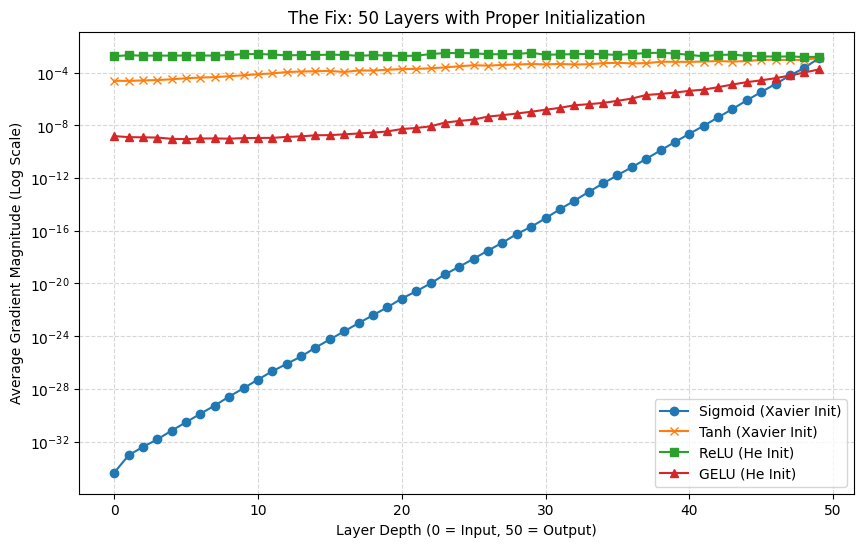

In [5]:
# Run Experiment with Proper Init
layers, grads_sigmoid_fix = check_gradients("Sigmoid", torch.sigmoid, custom_init=True)
_, grads_tanh_fix = check_gradients("Tanh", torch.tanh, custom_init=True)
_, grads_relu_fix = check_gradients("ReLU", F.relu, custom_init=True)
_, grads_gelu_fix = check_gradients("GELU", F.gelu, custom_init=True)

# Visualization
plt.figure(figsize=(10, 6))
plt.plot(layers, grads_sigmoid_fix, label="Sigmoid (Xavier Init)", marker='o')
plt.plot(layers, grads_tanh_fix, label="Tanh (Xavier Init)", marker='x')
plt.plot(layers, grads_relu_fix, label="ReLU (He Init)", marker='s')
plt.plot(layers, grads_gelu_fix, label="GELU (He Init)", marker='^')

plt.yscale('log')
plt.xlabel("Layer Depth (0 = Input, 50 = Output)")
plt.ylabel("Average Gradient Magnitude (Log Scale)")
plt.title("The Fix: 50 Layers with Proper Initialization")
plt.legend()
plt.grid(True, which="both", ls="--", alpha=0.5)
plt.show()

### Discussion (Part 3)
Compare this plot to the previous one:
* **ReLU / GELU:** The lines should be much flatter (horizontal). The signal is preserved all the way back to the input.
* **Tanh:** With Xavier initialization, Tanh becomes much more stable, although it can still struggle in extremely deep networks compared to ReLU.
* **Sigmoid:** Even with Xavier init, Sigmoid usually struggles because its maximum derivative is only $0.25$. Multiplying $0.25$ fifty times results in a tiny number regardless of initialization.

---

## Part 4: Domain Guide (A Practical Summary)

Choosing an activation function often depends on your data modality and network architecture.

| Domain | Recommended Activation | Why? |
| :--- | :--- | :--- |
| **Computer Vision (CNNs)** | **ReLU** or **SiLU (Swish)** | ReLU is efficient and fast. SiLU is used in modern nets like EfficientNet/YOLOv5 for slightly better accuracy. |
| **NLP / LLMs (Transformers)** | **GELU** or **SwishGLU** | GELU is smoother than ReLU, aiding optimization in very deep Transformers (BERT, GPT, Llama). |
| **Audio / Waveforms** | **GELU** or **Tanh** | Waveforms oscillate; Tanh preserves sign, while GELU handles smoothness well. |
| **Tabular / Scientific / Peptides** | **SELU** | Self-Normalizing Neural Networks (SNNs) typically use SELU to keep variance stable without Batch Normalization, which is helpful for noisy scientific data. |
| **Reinforcement Learning** | **Tanh** or **ReLU** | Policy networks often output bounded actions (Tanh), while value networks use ReLU. |

### Modern Trends
In 2025+, **Swish (SiLU)** and **GELU** are becoming the defaults for almost everything except extremely lightweight mobile models (where ReLU is still used for speed).